In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import itertools
import re
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

# Load Dataset

In [2]:
cc = pd.read_csv('../DS_Challenges/Credit_Card_Transaction/cc_info.csv')
transaction = pd.read_csv('../DS_Challenges/Credit_Card_Transaction/transactions.csv')

In [3]:
cc.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [4]:
transaction.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [5]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   credit_card        984 non-null    int64 
 1   city               984 non-null    object
 2   state              984 non-null    object
 3   zipcode            984 non-null    int64 
 4   credit_card_limit  984 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 38.6+ KB


In [6]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   credit_card                294588 non-null  int64  
 1   date                       294588 non-null  object 
 2   transaction_dollar_amount  294588 non-null  float64
 3   Long                       294588 non-null  float64
 4   Lat                        294588 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 11.2+ MB


In [7]:
len(cc.credit_card.unique())

984

In [8]:
len(transaction.credit_card.unique())

984

In [9]:
data = cc.merge(transaction, on = 'credit_card')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294588 entries, 0 to 294587
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   credit_card                294588 non-null  int64  
 1   city                       294588 non-null  object 
 2   state                      294588 non-null  object 
 3   zipcode                    294588 non-null  int64  
 4   credit_card_limit          294588 non-null  int64  
 5   date                       294588 non-null  object 
 6   transaction_dollar_amount  294588 non-null  float64
 7   Long                       294588 non-null  float64
 8   Lat                        294588 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 22.5+ MB


In [10]:
data.head()

,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat
0,1280981422329509,Dallas,PA,18612,6000,2015-08-05 00:59:19,11.94,-75.964527,41.353578
1,1280981422329509,Dallas,PA,18612,6000,2015-10-29 18:23:04,5.76,-76.019703,41.311467
2,1280981422329509,Dallas,PA,18612,6000,2015-10-25 17:50:48,25.84,-76.043031,41.291053
3,1280981422329509,Dallas,PA,18612,6000,2015-09-05 17:39:43,68.89,-75.944299,41.327282
4,1280981422329509,Dallas,PA,18612,6000,2015-09-04 14:12:59,27.01,-75.997259,41.352099


# Data manipulation

In [11]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data.head(3)

,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat,month,year
0,1280981422329509,Dallas,PA,18612,6000,2015-08-05 00:59:19,11.94,-75.964527,41.353578,8,2015
1,1280981422329509,Dallas,PA,18612,6000,2015-10-29 18:23:04,5.76,-76.019703,41.311467,10,2015
2,1280981422329509,Dallas,PA,18612,6000,2015-10-25 17:50:48,25.84,-76.043031,41.291053,10,2015


# Question 1

### identify those users that in your dataset never went above the monthly credit card limit. 

The goal of this is to automatically increase their limit. Can you send him the list of Ids?

In [12]:
data.credit_card_limit.unique()

array([ 6000, 16000, 14000, 18000, 20000, 21000,  4000, 15000,  5000,
       10000, 30000, 12000,  7000, 25000, 24000,  8000,  2000,  9000,
        3000, 40000, 32000, 35000, 33000, 28000, 27000, 42000, 36000,
       55000])

In [13]:
# see each user's monthly transaction_dollar_amount
user_month_transaction = data.groupby(['year','month','credit_card']).\
                         agg({'transaction_dollar_amount':'sum'}).\
                         reset_index()

# link credit_card_limit with ids
user_month_transaction = user_month_transaction.\
    merge(data[['year','month','credit_card','credit_card_limit']], on = ['year','month','credit_card'], how = 'left').\
    drop_duplicates()

# creat 'exceed' columns
user_month_transaction['exceed'] = user_month_transaction['transaction_dollar_amount']>user_month_transaction['credit_card_limit']

In [14]:
# sum up all the exceeding times of every user
user_month_transaction = user_month_transaction.groupby('credit_card').agg({'exceed':'sum'}).reset_index()

# choose the users who never exceeded before
user_not_exceed = user_month_transaction.loc[user_month_transaction['exceed']==0].credit_card.unique()

# show the number of qualified users
len(user_not_exceed)

862

In [15]:
# Show him the list of Ids 
pd.Series(user_not_exceed)

0      1003715054175576
1      1013870087888817
2      1023820165155391
3      1073931538936472
4      1077622576192810
             ...       
857    9946917923319410
858    9958678964376192
859    9961694231875562
860    9981251982982618
861    9986135779184360
Length: 862, dtype: int64

# Question 2

On the other hand, she wants you to implement an algorithm that as soon as a user goes above her monthly limit, it triggers an alert so that the user can be notified about that.

We assume here that at the beginning of the new month, user total money spent get reset to zero (i.e. she pays the card fully at the end of each month) 

Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day.

In [16]:
data['day'] = data['date'].dt.day
data.head()

,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat,month,year,day
0,1280981422329509,Dallas,PA,18612,6000,2015-08-05 00:59:19,11.94,-75.964527,41.353578,8,2015,5
1,1280981422329509,Dallas,PA,18612,6000,2015-10-29 18:23:04,5.76,-76.019703,41.311467,10,2015,29
2,1280981422329509,Dallas,PA,18612,6000,2015-10-25 17:50:48,25.84,-76.043031,41.291053,10,2015,25
3,1280981422329509,Dallas,PA,18612,6000,2015-09-05 17:39:43,68.89,-75.944299,41.327282,9,2015,5
4,1280981422329509,Dallas,PA,18612,6000,2015-09-04 14:12:59,27.01,-75.997259,41.352099,9,2015,4


In [17]:
def alert(data, month, day):
    """return the list of credit cards that exceed the credit_card_limit"""
    # sum up the amount of every user each day
    user_day_transaction = data.groupby(['credit_card','month','day']).agg({'transaction_dollar_amount':'sum'}).reset_index()
    # select the indices of the specific month
    user_specific_month = user_day_transaction.loc[user_day_transaction['month']==month]
    # cumsum amount of that day and the day before that day
    user_day_cumsum = user_specific_month.loc[user_specific_month['day']<=day].groupby('credit_card').agg({'transaction_dollar_amount':'sum'}).reset_index()
    # join data with credit_card_limit
    data_partial = data[['credit_card','month','credit_card_limit']]
    user_day_join = user_day_cumsum.merge(data_partial.loc[data_partial['month']==month],on = 'credit_card',how='left').drop_duplicates()
    # select the users that exceed the amount
    user_day_exceed = user_day_join.loc[user_day_join['transaction_dollar_amount']>user_day_join['credit_card_limit']]
    
    return user_day_exceed

In [18]:
alert(data, month = 8, day = 20)

,credit_card,transaction_dollar_amount,month,credit_card_limit
19612,2850146878241916,4012.81,8,4000
32355,3936887050542904,5352.07,8,4000
35055,4118286032166087,3416.52,8,3000
39570,4462290711836916,3119.53,8,2000
54010,5723635641134781,2161.30,8,2000
70909,7299183791723634,7074.49,8,7000
77661,7850942767136368,5704.00,8,4000
84713,8522875529951473,5860.89,8,5000
88628,8972201384562696,5266.08,8,5000


# Question 3

Finally, your boss is very concerned about frauds cause they are a huge cost for credit card companies. She wants you to implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further.

In [19]:
data.head()

,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat,month,year,day
0,1280981422329509,Dallas,PA,18612,6000,2015-08-05 00:59:19,11.94,-75.964527,41.353578,8,2015,5
1,1280981422329509,Dallas,PA,18612,6000,2015-10-29 18:23:04,5.76,-76.019703,41.311467,10,2015,29
2,1280981422329509,Dallas,PA,18612,6000,2015-10-25 17:50:48,25.84,-76.043031,41.291053,10,2015,25
3,1280981422329509,Dallas,PA,18612,6000,2015-09-05 17:39:43,68.89,-75.944299,41.327282,9,2015,5
4,1280981422329509,Dallas,PA,18612,6000,2015-09-04 14:12:59,27.01,-75.997259,41.352099,9,2015,4


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294588 entries, 0 to 294587
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   credit_card                294588 non-null  int64         
 1   city                       294588 non-null  object        
 2   state                      294588 non-null  object        
 3   zipcode                    294588 non-null  int64         
 4   credit_card_limit          294588 non-null  int64         
 5   date                       294588 non-null  datetime64[ns]
 6   transaction_dollar_amount  294588 non-null  float64       
 7   Long                       294588 non-null  float64       
 8   Lat                        294588 non-null  float64       
 9   month                      294588 non-null  int64         
 10  year                       294588 non-null  int64         
 11  day                        294588 non-null  int64   

I think there are two factors which impact a transaction is fraud or not:
1. if the transaction violates that user's consumption habit. For example, if a user spend less then 200 each transaction most of the time, then a transaction more than 1000 will be highly suspicious.
2. if user spend the money far from his home, although it is possible due to traveling, but it's still very suspicious.

There are some features that cannot be directly used, such as Long, Lat, city, state, zipcode. However, these information is important towards anomaly detection. One idea is to replace city, state, zipcode with the user's home latitude and longitude. In this work, to simplify the work, I use the `median` of Long and Lat as the indicator of user's home address.

### Prepare features

In [21]:
# calculate the median for Longtitude and Latitude
median = data.groupby('credit_card').agg({'Long':'median','Lat':'median'}).reset_index().rename(columns = {'Long':'long_median','Lat':'lat_median'})
data = data.merge(median, on = 'credit_card')
data.head()

,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat,month,year,day,long_median,lat_median
0,1280981422329509,Dallas,PA,18612,6000,2015-08-05 00:59:19,11.94,-75.964527,41.353578,8,2015,5,-75.971329,41.346369
1,1280981422329509,Dallas,PA,18612,6000,2015-10-29 18:23:04,5.76,-76.019703,41.311467,10,2015,29,-75.971329,41.346369
2,1280981422329509,Dallas,PA,18612,6000,2015-10-25 17:50:48,25.84,-76.043031,41.291053,10,2015,25,-75.971329,41.346369
3,1280981422329509,Dallas,PA,18612,6000,2015-09-05 17:39:43,68.89,-75.944299,41.327282,9,2015,5,-75.971329,41.346369
4,1280981422329509,Dallas,PA,18612,6000,2015-09-04 14:12:59,27.01,-75.997259,41.352099,9,2015,4,-75.971329,41.346369


In [22]:
# calculate the distance
data['distance'] = np.sqrt((data['Long']-data['long_median'])**2+(data['Lat']-data['lat_median'])**2)

For transaction and credit limit information, four more useful information are extracted:
- ratio of transactionn and transaction median
- ratio of transaction and credit limit

In [23]:
# calculate user transaction median
median = data.groupby('credit_card')['transaction_dollar_amount'].median().reset_index()
median = median.rename(columns={'transaction_dollar_amount': 'transaction_median'})
data = pd.merge(left=data, right=median, on='credit_card', how='left')

In [24]:
# calculate ratio of transaction and credit limit
data['transaction_to_limit'] = data['transaction_dollar_amount']/data['credit_card_limit']

In [25]:
# calculate ratio of transactionn and transaction median
data['transaction_to_median'] = data['transaction_dollar_amount'] / data['transaction_median']

In [26]:
data.sample(5)

,credit_card,city,state,zipcode,credit_card_limit,date,transaction_dollar_amount,Long,Lat,month,year,day,long_median,lat_median,distance,transaction_median,transaction_to_limit,transaction_to_median
289079,4027126453841428,Washington,NH,3280,20000,2015-08-06 22:11:20,137.34,-72.083582,43.175296,8,2015,6,-72.101272,43.172965,0.017843,76.31,0.006867,1.799764
201076,3344214228396727,El Paso,IL,61738,10000,2015-10-16 20:05:02,45.31,-89.022223,40.757314,10,2015,16,-89.059286,40.723869,0.049923,79.26,0.004531,0.571663
208789,6201975636402458,Washington,NH,3280,4000,2015-10-04 21:18:30,7.85,-72.158970,43.231497,10,2015,4,-72.090089,43.171155,0.091573,22.73,0.001962,0.345359
71155,3769271071419194,Washington,NH,3280,25000,2015-08-08 22:36:33,124.22,-158.207604,50.838074,8,2015,8,-72.099797,43.168819,86.448667,82.88,0.004969,1.498793
50306,1571950024675150,Atlanta,NY,14808,5000,2015-08-29 18:40:24,19.39,-77.473998,42.523639,8,2015,29,-77.477891,42.550659,0.027299,36.95,0.003878,0.524763


In [27]:
# drop useless features
data['weekday'] = data['date'].dt.weekday
data['hour'] = data['date'].dt.hour
labels = ['transaction_dollar_amount', 'Long', 'Lat', 'city', 'state', 'zipcode', 'credit_card_limit', 
          'date','month', 'day', 'year','long_median', 'lat_median', 'transaction_to_median']
data = data.drop(columns = labels)
data.head()

,credit_card,distance,transaction_median,transaction_to_limit,weekday,hour
0,1280981422329509,0.009912,34.37,0.001990,2,0
1,1280981422329509,0.059650,34.37,0.000960,3,18
2,1280981422329509,0.090560,34.37,0.004307,6,17
3,1280981422329509,0.033089,34.37,0.011482,5,17
4,1280981422329509,0.026556,34.37,0.004502,4,14


In [28]:
# save it for later use
data.to_csv('extend_transactions.csv',index=False)

### Reduce dimensions and visualize

In [29]:
X = data.drop(columns = ['credit_card','weekday','hour'])
X.describe()

,distance,transaction_median,transaction_to_limit
count,294588.000000,294588.000000,2.945880e+05
mean,1.993783,69.081697,6.608652e-03
std,17.336845,35.160028,1.310663e-02
min,0.000000,7.320000,2.857143e-07
25%,0.044965,43.590000,2.339661e-03
50%,0.063606,65.190000,4.112165e-03
75%,0.078059,89.710000,6.709219e-03
max,338.132513,222.290000,4.966000e-01


In [30]:
# normalize the data
scaler = StandardScaler()
norm_X = scaler.fit_transform(X)

In [31]:
# Use PCA to reduce feature matrix to 2D
pca = PCA()
X2d = pca.fit_transform(norm_X)
X2d = pd.DataFrame(X2d,columns = ['pc1','pc2','pc3'])[['pc1','pc2']]

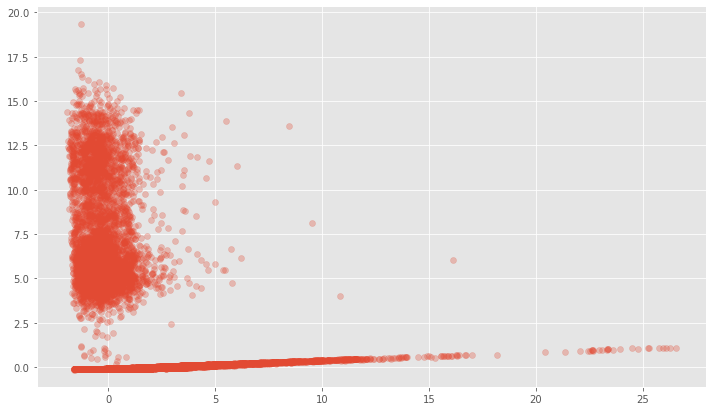

In [32]:
plt.style.use('ggplot')
plt.figure(figsize = (12,7))
plt.scatter(X2d.pc1,X2d.pc2,alpha=0.3)

There are different methods for unsupervised anomaly detection, such as Isolation Forest, One-Class SVM, DBSCAN and so on.

Here, for simplicity, only DBSCAN method with default parameters is implemented.

In [34]:
# build isolation forest model
forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, 
                         max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42)
forest = forest.fit(norm_X)
score = forest.decision_function(norm_X)
label = forest.predict(norm_X)

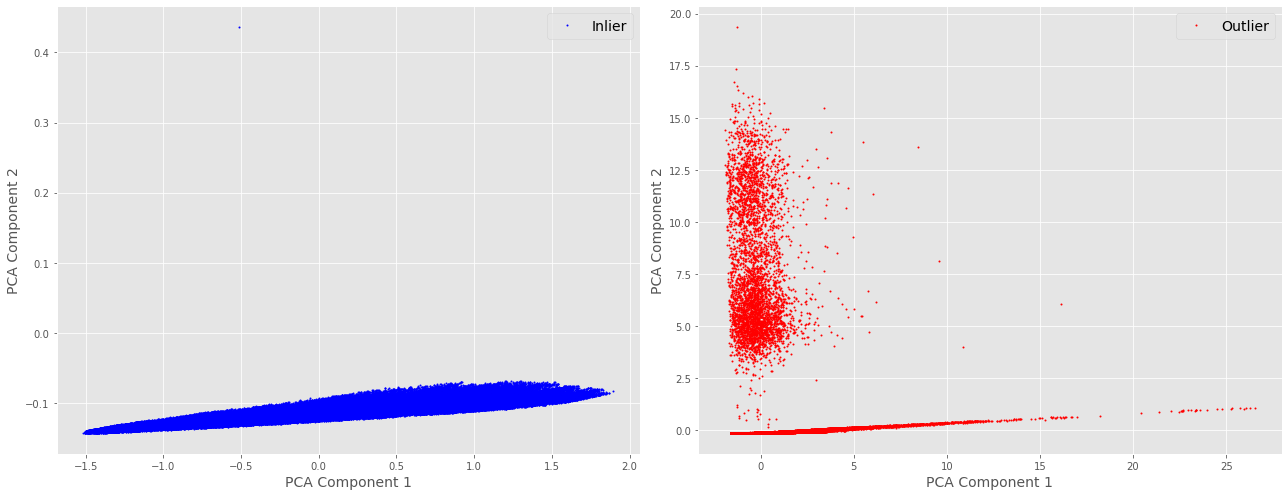

In [46]:
# visualization
inlier = X2d[label == 1]
outlier = X2d[label == -1]
"""xmin = X2d[:, 0].min() - 1
xmax = X2d[:, 0].max() + 1
ymin = X2d[:, 1].min() - 1
ymax = X2d[:, 1].max() + 1"""

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(inlier.loc[:,'pc1'], inlier.loc[:,'pc2'], 'b.', markersize=2, label='Inlier')
ax[0].set_xlabel('PCA Component 1', fontsize=14)
ax[0].set_ylabel('PCA Component 2', fontsize=14)
ax[0].legend(fontsize=14)
"""ax[0].set_xlim([xmin, xmax])
ax[0].set_ylim([ymin, ymax])"""
ax[1].plot(outlier.loc[:, 'pc1'], outlier.loc[:, "pc2"], 'r.', markersize=2, label='Outlier')
ax[1].set_xlabel('PCA Component 1', fontsize=14)
ax[1].set_ylabel('PCA Component 2', fontsize=14)
ax[1].legend(fontsize=14)
"""ax[1].set_xlim([xmin, xmax])
ax[1].set_ylim([ymin, ymax])"""
plt.tight_layout()
plt.show()